# CNNs for Digits Classification
This is a quick introduction into how to set up a Convolutional Neural Network to classify hand-drawn digits. Before getting started, I wanted to collect an unique set of data rather than relying to experience with the up- and downsides of "not-battle-tested" data. 

In order to do so, I created a (read modified an existing) JavaScript/HTML5 app and drew digits myself.

The resulting model and website including a quick summary of all steps as well as an interactive front-end can be found [here](http://digits.rvbin.com). The dataset created for this model can be found [here](https://drive.google.com/open?id=1J1G1jK8hotALkZZWR07fTjrGfZvLkH2y).

# Data Preprocessing
To make the images usable for any CNN model, it is helpful to transform the information into arrays. We'll feed those number arrays into our model.

In [42]:
import numpy as np
import math
import os, sys
import scipy
import skimage.transform as sktransform
import tensorflow as tf
import time

from collections import Counter
from IPython.display import clear_output
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

%matplotlib inline

random_state = 2018

In [2]:
PREP_PATH = "images/prep/"
os.listdir('images/prep/')

['1_image_13.png', '8_image_0.jpg']

In [3]:
test_img = '1_image_13.png'
test_img2 = '8_image_0.jpg'
path = PREP_PATH + test_img
path2 = PREP_PATH + test_img2

## Read in images
Let's see how a test image looks like. `PIL` offers some easy accesible functions to handle image data even in jupyter notebooks.

In [4]:
def load_and_turn_to_array(path):
    png = Image.open(path)
    png.load()
    return np.array(png)

In [5]:
test_image1 = load_and_turn_to_array(path)

The images have 4 channels and 256 x 256 pixels per channel. While the first 3 channels contain color information, the fourth dimension stores opacity values.

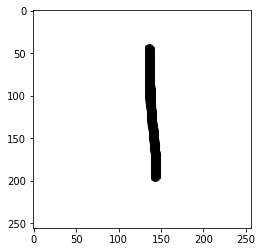

In [6]:
plt.imshow(test_image1)

Since this dataset deals with strictly black and white images, the alpha channel contains enough information for us to move forward.

In [7]:
def grab_only_alpha_channel(img):
    return img[:,:,3]

In [8]:
only_alpha = grab_only_alpha_channel(test_image1)

In [9]:
only_alpha.shape

(256, 256)

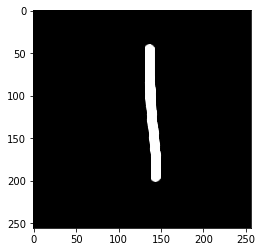

In [10]:
_ = plt.imshow(only_alpha, cmap='gray')

## Normalizing Values
To make it easier for the gradients to find a minimum and progress faster, it is helpful to normalize the pixel values and range them inbetween 0 to 1. This can be achieved by simply dividing all values by 255, it's maximum value.

In [11]:
only_alpha

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [12]:
def normalize_image(img):
    img = img / 255.
    return img

In [13]:
normalized_alpha = normalize_image(only_alpha)

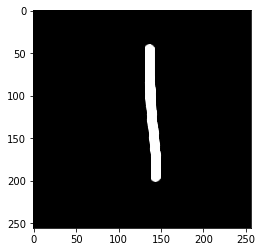

In [14]:
_ = plt.imshow(normalized_alpha, cmap='gray')

## Create training set

I handcrafted 101 images of every digit, to prepare a training and testing set. All these beauties are stored in the folder `images/digits/`. To download the images and reproduce the work in here, head over [here](https://drive.google.com/open?id=1J1G1jK8hotALkZZWR07fTjrGfZvLkH2y).

In [15]:
DIGITS_IMAGE_PATH = 'images/digits/'

def count_all_images(path):
    counter = 0
    for folder_name in os.listdir(path):
        if folder_name in [str(x) for x in range(10)]:  # if foldername is a number from 0 to 9
            for image_name in os.listdir(path + folder_name):
                if 'png' in image_name:
                    counter += 1
    return counter

In [16]:
img_count = count_all_images(DIGITS_IMAGE_PATH)
print ("There are {} images in all folders".format(img_count))

There are 1010 images in all folders


In order to use those, we're going to read them in, and store them in numpy arrays. Those will come in handy when we're building our model later on. I'll go over the steps in a bit but for now, the summary of the ```generate_X_and_y``` function is: Read in all data, create a Y and X vetor, turn those images into arrays and store them in the proper format.

> We'll hold on to the channel information - while it wouldn't be needed this format has evolved as a standard to deal with more complex information in i.e. RGB(A) format.

In [17]:
def generate_X_and_y(path, shape=(256, 256)):
    img_count = count_all_images(path)
    y_vect = np.zeros(shape=(img_count, 10))  # create empty vector for labels
    X_vect = np.zeros(shape=(img_count, shape[0], shape[1], 1))  # create empty vector for images
    counter = 0
    for folder_name in os.listdir(path):
        if folder_name in [str(x) for x in range(10)]:  # if foldername is a number from 0 to 9
            # access folder
            for file_name in os.listdir(path + folder_name):
                if "png" in file_name:
                    clear_output(wait=True)
                    print ("Working on image number {} (Label:  {} || Filename: {})".format(
                        counter, folder_name, file_name))
                    tmp_img = load_and_turn_to_array(path + folder_name + '/' + file_name)
                    tmp_img = grab_only_alpha_channel(tmp_img)
                    y_tmp = np.zeros(shape=(10), dtype=int)
                    y_tmp[int(folder_name)] = 1
                    y_vect[counter] = y_tmp
                    X_vect[counter, :, :, 0] = tmp_img
                    counter += 1
    return X_vect, y_vect

In [18]:
X_all, Y_all = generate_X_and_y(DIGITS_IMAGE_PATH, shape=(256,256))

Working on image number 1009 (Label:  9 || Filename: 9_image_72.png)


In [19]:
X_all.shape

(1010, 256, 256, 1)

In [20]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_all, Y_all, test_size=.4, stratify=Y_all, random_state=random_state)

In [21]:
X_dev, X_test, Y_dev, Y_test = train_test_split(
    X_test, Y_test, test_size=.5, stratify=Y_test, random_state=random_state)

## Show Images on a case-by-case basis
To help with the display of images we craft a swifty function, that displays any given number in our dataset. 

In [22]:
def print_number_and_image(X, Y, image_number):
    plt.imshow(X[image_number, :, :, 0], cmap='gray')
    plt.show()
    print ("Label: {}".format(Y[image_number]))
    return Y[image_number]

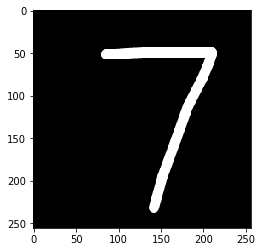

Label: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [23]:
print_number_and_image(X_all, Y_all, 777)  # prints label and plots image with index number 777 in X_all

As a quick sanity check, let's take a look at the information we processed and how its stored.

In [24]:
print ("Y_all contains {} labels stored as one-hot-encoded np.arrays of {} classes (digits 0 to 9).".format(
    *Y_all.shape))

Y_all contains 1010 labels stored as one-hot-encoded np.arrays of 10 classes (digits 0 to 9).


In [25]:
print ("X_all contains {} images with the ratio {} x {} and {} channel.".format(*X_all.shape))

X_all contains 1010 images with the ratio 256 x 256 and 1 channel.


After masking, we end up with following data sets.

In [26]:
print ("X_train - shape: {}".format(X_train.shape))
print ("Y_train - shape: {}".format(Y_train.shape))
print ("X_dev - shape: {}".format(X_dev.shape))
print ("Y_dev - shape: {}".format(Y_dev.shape))
print ("X_test - shape: {}".format(X_test.shape))
print ("Y_test - shape: {}".format(Y_test.shape))

X_train - shape: (606, 256, 256, 1)
Y_train - shape: (606, 10)
X_dev - shape: (202, 256, 256, 1)
Y_dev - shape: (202, 10)
X_test - shape: (202, 256, 256, 1)
Y_test - shape: (202, 10)


606 images for training and each 202 images for development and testing.

## Model Creation

Tensorflow offers a standardized way to create your own [custom estimators](https://www.tensorflow.org/get_started/custom_estimators). These estimators can be adjusted to fit your needs and structure. For our first base model we decided to go for the following setup:

* Two convolutional layers, of a kernel size 5 x 5 each. 
    * The first layer with 32 
    * The second with 64 filters
* Both apply same padding and are activated through a ReLu function
* After each convolutional layer max pooling is performed with a window size of 2x2 and a stride of 2. 
* After the second pooling step the multidimensional tensor is being flattened and fed through a fully connected layer with 1024 neurons. 
* This layer feeds into a fully connected layer with 10 units which determines the probability of the image being a certain class through softmax. 

In [27]:
def digit_cnn_base_fn(features, labels, mode):
    """
    Convolutional Neural Network model to recognize hand-written digits.
    """
    
    # input layer
    # [batch_size, image_width, image_height, channels]
    # -1 means batch_size is being automatically computed
    input_layer = tf.reshape(features["x"], [-1, 256, 256, 1])
    
    # first convolution
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    # pooling 1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    # second convolution
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    # pooling 2
    pool2 = tf.layers.max_pooling2d(
        inputs=conv2, 
        pool_size=[2, 2], 
        strides=2)
    
    # flatten data
    pool2_flat = tf.reshape(pool2, [-1, 64 * 64 * 64])
    
    # first fully connected dense layer
    dense = tf.layers.dense(
        inputs=pool2_flat, 
        units=1024, 
        activation=tf.nn.relu)
    
    # second fully connected dense "logits" layer
    logits = tf.layers.dense(inputs=dense, units=10)
    
    # if predicting and evaluating - generate predictions
    predictions = {
        "class": tf.argmax(logits, axis=1),
        "probabilities": tf.nn.softmax(logits)
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # if training and evaluating - calculate loss
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    # define training mode
    if mode == tf.estimator.ModeKeys.TRAIN:
        
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        eval_metrics_op = {
            "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["class"])
        }
        
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op, eval_metric_ops=eval_metrics_op)
    
    # define evaluation mode
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metrics_op = {
            "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["class"])
        }
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics_op)

Next the data is being processed and put into the right input format for this custom estimator.

In [28]:
train_data = X_train
train_data = train_data.astype(np.float32)

In [29]:
print ("The training data has a shape of {} (number of images, width, height, channels)".format(train_data.shape))

The training data has a shape of (606, 256, 256, 1) (number of images, width, height, channels)


In [30]:
print ("The evaluation labels have a shape of {} (number of labels, number of classes)".format(Y_train.shape))

The evaluation labels have a shape of (606, 10) (number of labels, number of classes)


In [31]:
train_labels = Y_train
eval_data = X_dev
eval_labels = Y_dev
eval_data = eval_data.astype(np.float32)

Next we link the custom function with the TensorFlow Estimator class and retrieve everything. 

In [32]:
tf.logging.set_verbosity(tf.logging.INFO)
digit_base_classifier = tf.estimator.Estimator(
    model_fn=digit_cnn_base_fn, model_dir="digit_base_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'digit_base_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc26130df60>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Turn into Distinct Encodings

In [33]:
def distinct_encoding(labels):
    y_nohe = np.zeros(shape=(labels.shape[0], 1), dtype=int)
    for idx, el in enumerate(labels):  # reformat into non-one-hot-encodings
        y_nohe[idx] = np.argmax(el)
    return y_nohe

In [34]:
y_train_nohe = distinct_encoding(train_labels)
y_train_nohe.shape

(606, 1)

In [35]:
train_base_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=y_train_nohe,
    batch_size=32,
    num_epochs=10,
    shuffle=True)

In [36]:
training_results = digit_base_classifier.train(
    input_fn=train_base_input_fn,
    steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into digit_base_model/model.ckpt.
INFO:tensorflow:loss = 14.315405, step = 1
INFO:tensorflow:global_step/sec: 9.74701
INFO:tensorflow:loss = 0.007737709, step = 101 (10.260 sec)
INFO:tensorflow:Saving checkpoints for 190 into digit_base_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.0024613673.


In [36]:
y_eval_nohe = distinct_encoding(eval_labels)

In [38]:
# Evaluate the model and print results
eval_base_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=y_eval_nohe,
    num_epochs=1,
    shuffle=False)
eval_results = digit_base_classifier.evaluate(input_fn=eval_base_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-07-24-22:45:38
INFO:tensorflow:Restoring parameters from digit_base_model/model.ckpt-190
INFO:tensorflow:Finished evaluation at 2018-07-24-22:45:39
INFO:tensorflow:Saving dict for global step 190: accuracy = 0.519802, global_step = 190, loss = 1.8483627
{'accuracy': 0.519802, 'loss': 1.8483627, 'global_step': 190}


## Model
Wait, what? Roughly 52 % accuracy on the development set? That can't be right. After running a few more tests an in-depth look at the numbers shows one possible reason. The model has an incredible high variance. In fact, on the training set, it shows close to 0 loss. It seems like the model is overfitting. In order to work our way around this problem, we take the first route and try regularizing the model. Adding a dropout layer with a dropout probability of 60 % should help to regularize the model. 

In [37]:
def digit_cnn_dropout_function(features, labels, mode):
    """
    Convolutional Neural Network model to recognize hand-written digits.
    """
    
    # input layer
    # [batch_size, image_width, image_height, channels]
    # -1 means batch_size is being automatically computed
    input_layer = tf.reshape(features["x"], [-1, 256, 256, 1])
    
    # first convolution
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    # pooling 1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    # second convolution
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    # pooling 2
    pool2 = tf.layers.max_pooling2d(
        inputs=conv2, 
        pool_size=[2, 2], 
        strides=2)
    
    # flatten data
    pool2_flat = tf.reshape(pool2, [-1, 64 * 64 * 64])
    
    # first fully connected dense layer
    dense = tf.layers.dense(
        inputs=pool2_flat, 
        units=1024, 
        activation=tf.nn.relu)
    
    # dropout layer
    dropout = tf.layers.dropout(
        inputs=dense, 
        rate=.6, 
        training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # second fully connected dense "logits" layer
    logits = tf.layers.dense(inputs=dense, units=10)
    
    # if predicting and evaluating - generate predictions
    predictions = {
        "class": tf.argmax(logits, axis=1),
        "probabilities": tf.nn.softmax(logits)
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # if training and evaluating - calculate loss
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    # define training mode
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # define evaluation mode
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metrics_op = {
            "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["class"])
        }
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics_op)

In [38]:
digit_dropout_classifier = tf.estimator.Estimator(
    model_fn=digit_cnn_dropout_function, model_dir="digit_dropout_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'digit_dropout_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc225265208>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [39]:
train_dropout_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=y_train_nohe,
    batch_size=32,
    num_epochs=10,
    shuffle=True)

In [45]:
digit_dropout_classifier.train(
    input_fn=train_dropout_input_fn,
    steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into digit_dropout_model/model.ckpt.
INFO:tensorflow:loss = 16.82959, step = 1
INFO:tensorflow:global_step/sec: 9.97865
INFO:tensorflow:loss = 0.22032285, step = 101 (10.023 sec)
INFO:tensorflow:Saving checkpoints for 190 into digit_dropout_model/model.ckpt.
INFO:tensorflow:Loss for final step: 0.016385254.


In [46]:
# Evaluate the model and print results
eval_dropout_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=y_eval_nohe,
    num_epochs=1,
    shuffle=False)
eval_results = digit_dropout_classifier.evaluate(input_fn=eval_dropout_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-07-24-22:46:52
INFO:tensorflow:Restoring parameters from digit_dropout_model/model.ckpt-190
INFO:tensorflow:Finished evaluation at 2018-07-24-22:46:53
INFO:tensorflow:Saving dict for global step 190: accuracy = 0.54950494, global_step = 190, loss = 1.7509946
{'accuracy': 0.54950494, 'loss': 1.7509946, 'global_step': 190}


### Accuracy up - loss down
Well. Looks like we got rid of some of the variance. And we slightly increased the accuracy. For a supervised learning task with 10 classes scoring 54% is still better than random guessing (which would yield around 10% accuracy) but we should be able to do better. Even with 10 epochs, the model should be able to perform better. Since we got rid of the overfitting problem, and seem to have a solid baseline it's time to move on and investigate the data.

As widely known, neural nets perform best if enough data is being funneled into them. A total dataset of 1010 images hardly counts as exhaustive. (Even though gathering those 1010 images took quite some painting time). Luckily there might be hope for us that might free us up some time that we can spend watching cute animals rather than drawing 10,000 more images. `Data augmentation` to the rescue.

## Data Augmentation
By simply shifting and rotating the images we should be able to vary the images so much that these generated images could count as new data. Let's try it. To perform this efficiently and make it faster to train we'll resize the existing images as well. Generating `28x28` pixel images.

### Zoom Shift
First, to take into account smaller numbers as well as to make the model invariant to the drawing position we'll zoom out of the image and place the smaller digit in all four corners of the image. In combination with rotations this should give a broad variety of images to train on. (And also help with hiding my terrible hand-writing).

In [113]:
def zoom_out_and_shift(img, label):
    zeros_img = []
    labels = [label] * 4
    for i in range(4):
        zeros_img.append(np.copy(np.zeros_like(img)))
    zoomed_img = scipy.ndimage.zoom(img[:,:,0], .65)
    zeros_img[0][:zoomed_img.shape[0],:zoomed_img.shape[1],0] = zoomed_img  # top left
    zeros_img[1][-zoomed_img.shape[0]:,:zoomed_img.shape[1],0] = zoomed_img  # bottom left
    zeros_img[2][:zoomed_img.shape[0],-zoomed_img.shape[1]:,0] = zoomed_img  # top right
    zeros_img[3][-zoomed_img.shape[0]:,-zoomed_img.shape[1]:,0] = zoomed_img  # bottom right
    return zeros_img, labels

In [114]:
# zoom out and shift image to four corners
X_zoom, Y_zoom = [], []
for ximg, ylabel in zip(X_train, Y_train):
    X_zoom.append(ximg)
    Y_zoom.append(ylabel)
    xzoom_tmp, yzoom_tmp = zoom_out_and_shift(ximg, ylabel)
    X_zoom.extend(xzoom_tmp)
    Y_zoom.extend(yzoom_tmp)

After transformation for any of the 606 trainign examples 4 new images are added to the list. Those images look like this:

In [115]:
def plot_zoom_images(xzoom, orig):
    plt_images = []
    plt_images.append(orig)
    plt_images.extend(xzoom)
    title_list = ['original', 'top_left', 'bottom_left', 'top_right', 'bottom_right']
    w=10
    h=10
    fig=plt.figure(figsize=(14, 4))
    columns = 5
    rows = 1
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(plt_images[i-1][:,:,0], cmap='gray')
        plt.title(title_list[i-1])
        plt.axis('off')
    plt.show()

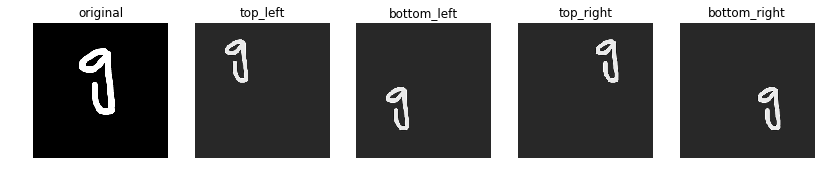

In [116]:
plot_zoom_images(xzoom_tmp, ximg)

In [117]:
print ('After zoom augmentation there are {:,} images in the dataset.'.format(len(X_zoom)))

After zoom augmentation there are 3,030 images in the dataset.


## Resize and Rotate
Afterwards we'll resize and rotate those images to add even more images to the dataset.

In [118]:
def resize(X_aug):
    X_new_aug = []
    for X_tmp in X_aug:
        X_new_aug.append(sktransform.resize(X_tmp, (28, 28)))
    return np.array(X_new_aug)

In [119]:
X_train_resized = resize(X_zoom)

/home/rvbin/.virtualenvs/digits_classifier/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/rvbin/.virtualenvs/digits_classifier/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [120]:
X_train_resized.shape

(3030, 28, 28, 1)

In [121]:
def augment_images(X_train, Y_train):
    aug_list = []
    aug_y_list = []
    for ix, XY in enumerate(zip(X_train, Y_train)):
        X_tmp, Y_tmp = XY[0], XY[1]
        tmp_label = np.argmax(Y_tmp)
        if ix % 10 == 0:
            clear_output(True)
            print ('{} / {}'.format(ix, len(X_train)))
        
        for rot_num in range(1, 21, 2):
            rot_img = scipy.ndimage.interpolation.rotate(X_tmp, rot_num, reshape=False)
            aug_list.append(rot_img)
            aug_y_list.append(tmp_label)
        for rot_num in range(-20, 0, 2):
            rot_img = scipy.ndimage.interpolation.rotate(X_tmp, rot_num, reshape=False)
            aug_list.append(rot_img)
            aug_y_list.append(tmp_label)
            
    
    return np.array(aug_list), np.array(aug_y_list)

In [122]:
X_train_aug, y_train_aug = augment_images(X_train_resized, Y_zoom)

3020 / 3030


In [126]:
print ('After augmentation and resizing we have {:,} images with shape {} x {} x {}'.format(*X_train_aug.shape))

After augmentation and resizing we have 60,600 images with shape 28 x 28 x 1


Those images look similar to this:

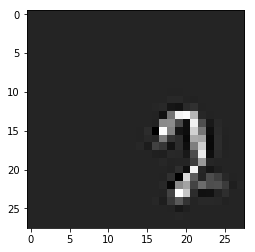

Label: 2


2

In [130]:
print_number_and_image(X_train_aug, y_train_aug, 23484)

## Dev Set Pre-Processing
Now we have to do the same pre-processing to the development set. We won't augment the data set since we'll take it as an estimation on how well the model performs on unseen data.

In [131]:
X_dev.shape

(202, 256, 256, 1)

In [132]:
X_dev_resized = resize(X_dev)

/home/rvbin/.virtualenvs/digits_classifier/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/rvbin/.virtualenvs/digits_classifier/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [133]:
X_dev_resized.shape

(202, 28, 28, 1)

In [134]:
X_dev_resized = X_dev_resized.astype(np.float32)

In [135]:
X_train_aug = X_train_aug.astype(np.float32)

## Model with Dropout
Below is a sketch of the model. To help the model generalize better to new data, a dropout step between the first dense and the final layer is introduced

![CNN Structure](nb_img/cnn_structure.png)

In [169]:
def digit_cnn_aug_dropout_function(features, labels, mode):
    """
    Convolutional Neural Network model to recognize hand-written digits.
    """
    
    # input layer
    # [batch_size, image_width, image_height, channels]
    # -1 means batch_size is being automatically computed
    input_layer = tf.reshape(features["x"], [-1, 28, 28, 1])
    
    # first convolution
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    # pooling 1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    
    # second convolution
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    
    # pooling 2
    pool2 = tf.layers.max_pooling2d(
        inputs=conv2, 
        pool_size=[2, 2], 
        strides=2)
    
    # flatten data
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    
    # first fully connected dense layer
    dense = tf.layers.dense(
        inputs=pool2_flat, 
        units=1024, 
        activation=tf.nn.relu)
    
    # dropout layer
    dropout = tf.layers.dropout(
        inputs=dense, 
        rate=.4, 
        training=mode == tf.estimator.ModeKeys.TRAIN)
    
    # second fully connected dense "logits" layer
    logits = tf.layers.dense(inputs=dense, units=10)
    
    # if predicting and evaluating - generate predictions
    predictions = {
        "class": tf.argmax(logits, axis=1),
        "probabilities": tf.nn.softmax(logits)
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    # if training and evaluating - calculate loss
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    # define training mode
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)
    
    # define evaluation mode
    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metrics_op = {
            "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["class"])
        }
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metrics_op)

In [170]:
digit_aug_dropout_classifier = tf.estimator.Estimator(
    model_fn=digit_cnn_aug_dropout_function, model_dir="digit_final")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'digit_final', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc2245c7278>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In addition the data is normalized to help the model converge quicker. 

In [152]:
X_train_aug_norm = X_train_aug / 255.

In [153]:
X_train_aug_norm[0].shape

(28, 28, 1)

In [154]:
y_dev_real = []
for a in Y_dev:
    y_dev_real.append(np.argmax(a))

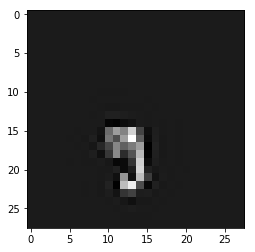

Label: 9


In [155]:
_ = print_number_and_image(X_train_aug_norm, y_train_aug, 244)

Making sure the stratification has worked properly and all numbers are equally represented in the evaluation data set,

In [156]:
Counter(y_dev_real)

Counter({0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 21, 8: 21, 9: 20})

In [189]:
train_aug_dropout_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train_aug_norm},
    y=y_train_aug,
    batch_size=32,
    num_epochs=100,
    shuffle=True)

In [190]:
digit_aug_dropout_classifier.train(
    input_fn=train_aug_dropout_input_fn,
    steps=1000)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from digit_final/model.ckpt-4000
INFO:tensorflow:Saving checkpoints for 4001 into digit_final/model.ckpt.
INFO:tensorflow:loss = 0.046797678, step = 4001
INFO:tensorflow:global_step/sec: 264.294
INFO:tensorflow:loss = 0.000934153, step = 4101 (0.379 sec)
INFO:tensorflow:global_step/sec: 336.105
INFO:tensorflow:loss = 0.03070413, step = 4201 (0.297 sec)
INFO:tensorflow:global_step/sec: 327.893
INFO:tensorflow:loss = 0.005239717, step = 4301 (0.305 sec)
INFO:tensorflow:global_step/sec: 311.907
INFO:tensorflow:loss = 0.0116049675, step = 4401 (0.321 sec)
INFO:tensorflow:global_step/sec: 340.348
INFO:tensorflow:loss = 0.0016865698, step = 4501 (0.294 sec)
INFO:tensorflow:global_step/sec: 345.498
INFO:tensorflow:loss = 0.0021787176, step = 4601 (0.290 sec)
INFO:tensorflow:global_step/sec: 347.513
INFO:tensorflow:loss = 0.00015165872, step = 4701 (0.288 sec)
INFO:tensorflow:global_step/sec: 305.42
INFO:tensorflo

In [191]:
X_dev_resized_norm = X_dev_resized / 255.

In [192]:
y_dev_nohe = distinct_encoding(Y_dev)

In [193]:
# Evaluate the model and print results
eval_dropout_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_dev_resized_norm},
    y=y_dev_nohe,
    num_epochs=1,
    shuffle=False)
eval_results = digit_aug_dropout_classifier.evaluate(input_fn=eval_dropout_input_fn)
print(eval_results)

INFO:tensorflow:Starting evaluation at 2018-07-25-15:39:39
INFO:tensorflow:Restoring parameters from digit_final/model.ckpt-5000
INFO:tensorflow:Finished evaluation at 2018-07-25-15:39:39
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.9752475, global_step = 5000, loss = 0.117541224
{'accuracy': 0.9752475, 'loss': 0.117541224, 'global_step': 5000}


After the first training process the evaluation accuracy already beats 95%. By repeating the training process another 3 times we're able to increase this to 97.52 %. 

# Testing the Model
Let's see how the model is performing on data it has not seen yet. Since we used the development set for - well - development, it's highly likely we've been secretly overfitting to reduce the error rate on that set. Now it's time to put this to the test and get a good estimation on how well - or poor - we might perform in the real world of digit classification. 

## Trial Predictions
First let's check out the prediction process on some sample data. We'll be using three digits from the training set and go through the prediction pipeline. This is the same function that will interface with any image data a user will input to the application.

In [204]:
list_of_examples = [2566, 1999, 345]
pred_data = X_train_aug_norm[list_of_examples]

In [205]:
pred_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": pred_data},
    shuffle=False)

In [259]:
pred_results = digit_aug_dropout_classifier.predict(pred_input_fn)

In [260]:
for pred in pred_results:
    print ('Class: {} - Probabilities: '.format(pred['class']))
    output_str = ''
    for a, b in enumerate(pred['probabilities']):
        output_str += str(a) + ' (' + str(round(b * 100., 2)) + ' %) '
    print (output_str)
    #print (pred['class'], pred['probabilities'])

INFO:tensorflow:Restoring parameters from digit_final/model.ckpt-5000
Class: 3 - Probabilities: 
0 (0.0 %) 1 (0.0 %) 2 (0.0 %) 3 (100.0 %) 4 (0.0 %) 5 (0.0 %) 6 (0.0 %) 7 (0.0 %) 8 (0.0 %) 9 (0.0 %) 
Class: 2 - Probabilities: 
0 (0.0 %) 1 (0.0 %) 2 (100.0 %) 3 (0.0 %) 4 (0.0 %) 5 (0.0 %) 6 (0.0 %) 7 (0.0 %) 8 (0.0 %) 9 (0.0 %) 
Class: 8 - Probabilities: 
0 (0.14 %) 1 (0.0 %) 2 (0.0 %) 3 (0.01 %) 4 (0.0 %) 5 (0.0 %) 6 (0.0 %) 7 (0.0 %) 8 (95.67 %) 9 (4.18 %) 


Let's do a quick sanity check that we're predicting the correct digits again.

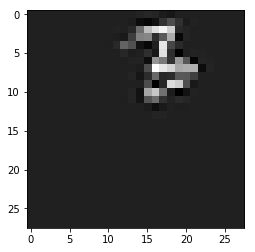

Label: 3


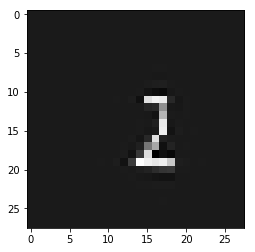

Label: 2


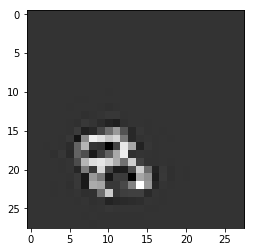

Label: 8


In [261]:
for example in list_of_examples:
    print_number_and_image(X_train_aug, y_train_aug, example)

In [262]:
X_test.shape

(202, 256, 256, 1)

Next we'll resize and normalize the test set as well. For the application to work well we need to incorporate this pre-processing step into the pipeline for new images.

In [196]:
X_test_resized = resize(X_test)
X_test_resized_norm = X_test_resized / 255.
X_test_resized_norm = X_test_resized_norm.astype(np.float32)

/home/rvbin/.virtualenvs/digits_classifier/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/rvbin/.virtualenvs/digits_classifier/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Encode y labels from one-hot-encoding to a distinct representation of the class.

In [200]:
Y_test_nohe = distinct_encoding(Y_test)

Sanity check that X and y data matches.

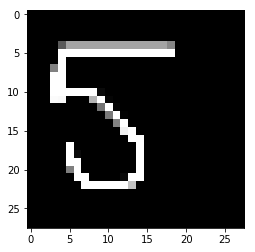

Label: [5]


array([5])

In [201]:
print_number_and_image(X_test_resized_norm, Y_test_nohe, 150)

In [203]:
test_dropout_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test_resized_norm},
    y=Y_test_nohe,
    num_epochs=1,
    shuffle=False)
test_results = digit_aug_dropout_classifier.evaluate(input_fn=test_dropout_input_fn)
print(test_results)

INFO:tensorflow:Starting evaluation at 2018-07-25-16:03:59
INFO:tensorflow:Restoring parameters from digit_final/model.ckpt-5000
INFO:tensorflow:Finished evaluation at 2018-07-25-16:03:59
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.9653465, global_step = 5000, loss = 0.18451256
{'accuracy': 0.9653465, 'loss': 0.18451256, 'global_step': 5000}


A 96.53% accuracy on the test set. That's quite the result given we started off with only 1010 images.

## Training Pre-Trained Model
In case you were wondering how to train an existing model with new data. Here is the gist of it. It's essentially just loading the last checkpoint and funnels new training data into the model. 

In [263]:
def get_new_unseen_example(test_img = 'images/handtest/3.png'):
    im = Image.open(test_img)
    im.thumbnail((28,28), Image.ANTIALIAS)
    test_img_arr = np.array(im)[:,:,3]
    test_img_right_format = np.zeros(shape=(28,28,1))
    test_img_right_format[:,:,0] = test_img_arr
    test_img_right_format = test_img_right_format.astype(np.float32)
    return test_img_right_format

In [268]:
new_image = get_new_unseen_example()

In [272]:
# for single images we need to make sure that the 
# format matches the architecture (1, 28, 28, 1) - (# images, size, size, channel)
new_X = np.zeros(shape=(1,28,28,1))
new_X[0,:,:,:] = new_image
new_X = new_X.astype(np.float32)
new_X = new_X / 255.

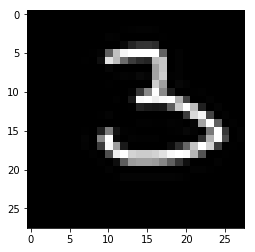

In [273]:
plt.imshow(new_X[0, :,:,0], cmap='gray')

Next, we need a label to train with as well. In the application this information comes from a drop-down menu.

In [274]:
new_Y = np.zeros(shape=(1, 1), dtype=int)
new_Y[0] = 3

In [275]:
train_new_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": new_X},
    y=new_Y,
    batch_size=1,  # because we're inputting one image
    num_epochs=4,
    shuffle=True)

In [276]:
test.train(
    input_fn=train_new_input_fn,
    steps=20)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from digit_final/model.ckpt-5000
INFO:tensorflow:Saving checkpoints for 5001 into digit_final/model.ckpt.
INFO:tensorflow:loss = 4.76836e-06, step = 5001
INFO:tensorflow:Saving checkpoints for 5004 into digit_final/model.ckpt.
INFO:tensorflow:Loss for final step: 6.198864e-06.
